In [1]:
import copy
import glob
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
import time
import tempfile
import shutil, shlex


from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from datetime import datetime
from funcs import *
from simulation_imports import *
from subprocess import check_call, STDOUT
from xspec import Xset, Plot, AllData, ModelManager, Spectrum, Model, AllModels, Fit

plt.style.use(astropy_mpl_style)


In [2]:
tmpDir = tempfile.mkdtemp()
os.environ["PFILES"] = tmpDir + ":" + os.environ["PFILES"]
os.environ["HEADASNOQUERY"] = ""
os.environ["HEADASPROMPT"] = "/dev/null/"
SIXTE = os.environ["SIXTE"]
xmldir = "{}/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row".format(SIXTE)

#xmldir="./xmldir"

## Ligth curve

### Simputfile call with the spectrum mcrab.xcm (same as the one created in "tutorial-general-intro.ipynb") with ligth curve

In [30]:
base = "mcrab"
xcm = "{}.xcm".format(base)

mcmod = Model("phabs*pegpwrlw")
mcmod.phabs.nH = 0.2
mcmod.pegpwrlw.PhoIndex = 2.05
mcmod.pegpwrlw.eMin = 2.
mcmod.pegpwrlw.eMax = 10.
mcmod.pegpwrlw.norm = 21.6
mcmod.show()

rewrite = True
if rewrite:
    if os.path.exists(xcm):
            os.remove(xcm)
    Xset.save(xcm)
else:
    print("Xspec file ({}) already exists: it will no be overwritten".format(xcm)) 

In [31]:
simput_lightcurve = '{}_lightcurve.fits'.format(base)
rewrite = True
if rewrite:
    if os.path.exists(simput_lightcurve):
        os.remove(simput_lightcurve)
    # Simputfile with the lightcurve
    comm = ("simputfile Simput=mcrab_lightcurve.fits Src_Name=first RA=0.0  Dec=0.0 srcFlux=2.137e-11 Elow=0.1 Eup=15 NBins=1000 logEgrid=yes Emin=2 Emax=10 MJDREF=55000 " +
        "LCFile=example_lightcurve.dat XSPECFile=mcrab.xcm clobber=True")
    run_comm(comm, "Creating simputfile")
    
else:
       
    print("SIMPUT file ({}) already exists: it will not be overwritten".format(simput_lightcurve)) 
            


Creating simputfile
simputfile Simput=mcrab_lightcurve.fits Src_Name=first RA=0.0  Dec=0.0 srcFlux=2.137e-11 Elow=0.1 Eup=15 NBins=1000 logEgrid=yes Emin=2 Emax=10 MJDREF=55000 LCFile=example_lightcurve.dat XSPECFile=mcrab.xcm clobber=True


### Example with lightcurve with the flux increasing linearly to 1000


In [43]:
lcurve = "mcrab_lc_tozero.txt"
t = np.linspace(0, 1000, 1000)
flx = np.linspace(1, 0, 1000)
a = np.array([t, flx])
np.savetxt(lcurve, a.T)

#create simputfile
rewrite = True
simputfile = "mcrab_lightcurve_tozero.fits"
if rewrite:
    if os.path.exists(simputfile):
        os.remove(simputfile)
    comm = ("simputfile Simput={} Src_Name=first RA=0. Dec=0. srcFlux=2.16E-11 Elow=0.01 Eup=20. ".format(simputfile) +
            "NBins=1000 logEgrid=yes Emin=2. Emax=10. XSPECFile=mcrab.xcm clobber=yes MJDREF=55000 LCFile={}".format(lcurve))
    run_comm(comm, 'Creating simput file')
else:
    print("SIMPUT file {} exists and will not be overwritten".format(simputfile))

Creating simput file
simputfile Simput=mcrab_lightcurve_tozero.fits Src_Name=first RA=0. Dec=0. srcFlux=2.16E-11 Elow=0.01 Eup=20. NBins=1000 logEgrid=yes Emin=2. Emax=10. XSPECFile=mcrab.xcm clobber=yes MJDREF=55000 LCFile=mcrab_lc_tozero.txt


In [44]:
# run simulation with simputfile from lightcurve
evtfile = "mcrab_lightcurve_tozero_evt.fits"
xml = "{}/ld_wfi_ff_large.xml".format(xmldir)

rewrite = True
if rewrite:
    if os.path.exists(evtfile):
        os.remove(evtfile)
    comm = ("runsixt XMLFile={} RA=0. Dec=0. Prefix='' Simput={} EvtFile={} Exposure=1000 clobber=yes".format(xml, simputfile, evtfile))
    run_comm(comm, "Running simulation of lightcurve data")
else:
    print("Simulations file ({}) already exists: it will not be overwritten".format(evtfile))

Running simulation of lightcurve data
runsixt XMLFile=/home/dgiron/sixtebin/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row/ld_wfi_ff_large.xml RA=0. Dec=0. Prefix='' Simput=mcrab_lightcurve_tozero.fits EvtFile=mcrab_lightcurve_tozero_evt.fits Exposure=1000 clobber=yes


Creating lightcurve
makelc EvtFile=mcrab_lightcurve_tozero_evt.fits Lightcurve=mcrab_tozero_lc.lc length=1000.0 dt=1.0
Converting lc to TIME, COUNTS
fdump infile='mcrab_tozero_lc.lc[COUNTS][col TIME=#row*TIMEDEL, COUNTS]' clobber=yes outfile=check_lc.txt col='-' row='-' prhead=no showrow=no showunit=no


Text(0, 0.5, 'Counts')

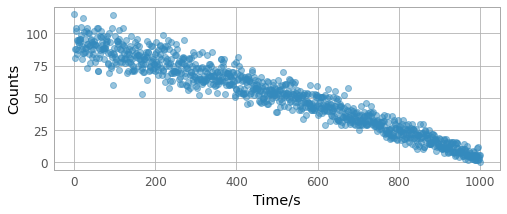

In [45]:
# create light curve & verify that it decreases to zero
lcurve = "mcrab_tozero_lc.lc"
rewrite = True
if rewrite:
    if os.path.exists(lcurve):
        os.remove(lcurve)
    comm = ("makelc EvtFile={} Lightcurve={} length=1000.0 dt=1.0".format(evtfile, lcurve))
    run_comm(comm, "Creating lightcurve")
else:
    print("Light curve ({}) already exists: it will not be overwritten".format(lcurve))
    
# convert light curve to TIME COUNTS to plot
comm = ("fdump infile='{}[COUNTS][col TIME=#row*TIMEDEL, COUNTS]' clobber=yes outfile=check_lc.txt col='-' row='-' ".format(lcurve) +
        "prhead=no showrow=no showunit=no")
run_comm(comm, "Converting lc to TIME, COUNTS")
datalc = pandas.read_table("check_lc.txt", skiprows=0, sep="\s+")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
ax.plot(datalc.TIME, datalc.COUNTS,'o', alpha=0.5)
ax.set_xlabel("Time/s")
ax.set_ylabel("Counts")


Creating lightcurve
makelc EvtFile=mcrab_lightcurve_tozero_evt.fits Lightcurve=sim_mcrab_tozero_bs2.lc length=1000.0 dt=2.0
Converting lc to TIME, RATE
fdump infile='sim_mcrab_tozero_bs2.lc[COUNTS][col TIME=#row*TIMEDEL, RATE=COUNTS/TIMEDEL]' clobber=yes outfile=check_lc_bs2.txt col='-' row='-' prhead=no showrow=no showunit=no
0         2.0
1         4.0
2         6.0
3         8.0
4        10.0
        ...  
495     992.0
496     994.0
497     996.0
498     998.0
499    1000.0
Name: TIME, Length: 500, dtype: float64


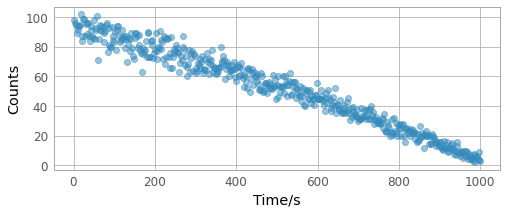

In [47]:
# extract lc again but now with a bin size of 2s . Plot counts/binsize
lcurve = "sim_mcrab_tozero_bs2.lc"
rewrite = True
if rewrite:
    if os.path.exists(lcurve):
        os.remove(lcurve)
    # Only changes dt ---> dt=2.0
    comm = ("makelc EvtFile={} Lightcurve={} length=1000.0 dt=2.0".format(evtfile, lcurve))
    run_comm(comm, "Creating lightcurve")
else:
    print("Light curve ({}) already exists: it will not be overwritten".format(lcurve))
      
# convert light curve to TIME COUNTS to plot
comm = ("fdump infile='{}[COUNTS][col TIME=#row*TIMEDEL, RATE=COUNTS/TIMEDEL]' clobber=yes ".format(lcurve) +
        "outfile=check_lc_bs2.txt col='-' row='-' prhead=no showrow=no showunit=no")
run_comm(comm, "Converting lc to TIME, RATE")
datalc = pandas.read_table("check_lc_bs2.txt", skiprows=0, sep="\s+")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
ax.plot(datalc.TIME, datalc.RATE,'o', alpha=0.5)
ax.set_xlabel("Time/s")
ax.set_ylabel("Counts")
print(datalc.TIME)

## Periodic variability

### $\textbf{Exercise}$: Download the above SIMPUT of the Crab and compare it with the time variable SIMPUT you created in Sect. 10.3.1. Note that the light curve extension in the above file you just downloaded has a different name (which?). Can you spot all differences in the light curve extension between these two SIMPUT files?


In [36]:
f_lc = fits.open("mcrab_lightcurve_tozero.fits")
f_pv = fits.open('crab.simput')
print('Light curve: ')
f_lc.info()
print('Periodic source variability: ')
f_pv.info()

print('Differences between ligth curve and periodic source variability "TIMING" extension')
print(f_lc[3].columns.names)
print(f_pv[3].columns.names)

Light curve: 
Filename: mcrab_lightcurve_tozero.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SRC_CAT       1 BinTableHDU     44   1R x 12C   [J, 32A, D, D, E, E, E, E, E, 32A, 32A, 32A]   
  2  SPECTRUM      1 BinTableHDU     21   1R x 3C   [1PE(1000), 1PE(1000), 48A]   
  3  TIMING        1 BinTableHDU     21   1000R x 2C   [D, E]   
Periodic source variability: 
Filename: crab.simput
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SRC_CAT       1 BinTableHDU     40   2R x 10C   [J, 11A, E, E, E, E, E, 28A, 9A, 14A]   
  2  SPECTRUM      1 BinTableHDU     21   2R x 3C   [49999E, 49999E, 6A]   
  3  LIGHTCURVE    1 BinTableHDU     28   46R x 2C   [D, D]   
  4  IMAGE         1 ImageHDU        23   (1024, 1024)   uint8   
Differences between ligth curve and periodic source variability "TIMING" extension
['TIME', 'FLUX']
['PHASE', 'FLUX']


### Add a QPO with a high Q-factor at a frequency of 0.01 Hz to the script that generated mcrab.fits. Then rerun the simulation and extract a light curve again.

In [37]:
simput_lightcurve_pwr = '{}_lightcurve_pwr.fits'.format(base)
rewrite = True
if rewrite:
    
    if os.path.exists(simput_lightcurve_pwr):
        os.remove(simput_lightcurve_pwr)
    # QPO added with Q1f, Q1Q, Q1rms
    comm = ("simputfile Simput={} Src_Name=first RA=0.0  Dec=0.0 srcFlux=2.137e-11 Elow=0.1 Eup=15 NBins=1000 logEgrid=yes Emin=2 Emax=10 MJDREF=55000 ".format(simput_lightcurve_pwr) +
        " XSPECFile=mcrab.xcm Q1f=0.01 Q1Q=4 Q1rms=0.01 clobber=True ")
    run_comm(comm, "Creating simputfile")
    
else:
    print("SIMPUT file ({}) already exists: it will not be overwritten".format(simput_lightcurve_pwr)) 

#run simulation with simputfile from lightcurve
evtfile = "evt_mcrab_lightcurve_pwr.fits"
xmldir = "{}/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row".format(SIXTE)
xml = "{}/ld_wfi_ff_large.xml".format(xmldir)

rewrite = True
if rewrite:
    if os.path.exists(evtfile):
        os.remove(evtfile)
    comm = ("runsixt XMLFile={} RA=0. Dec=0. Prefix='' Simput={} EvtFile={} Exposure=1000 clobber=yes".format(xml, simput_lightcurve_pwr, evtfile))
    run_comm(comm, "Running simulation of lightcurve data")
else:
    print("Simulations file ({}) already exists: it will not be overwritten".format(evtfile))

Creating simputfile
simputfile Simput=mcrab_lightcurve_pwr.fits Src_Name=first RA=0.0  Dec=0.0 srcFlux=2.137e-11 Elow=0.1 Eup=15 NBins=1000 logEgrid=yes Emin=2 Emax=10 MJDREF=55000  XSPECFile=mcrab.xcm Q1f=0.01 Q1Q=4 Q1rms=0.01 clobber=True 
Running simulation of lightcurve data
runsixt XMLFile=/home/dgiron/sixtebin/share/sixte/instruments/athena-wfi/wfi_wo_filter_15row/ld_wfi_ff_large.xml RA=0. Dec=0. Prefix='' Simput=mcrab_lightcurve_pwr.fits EvtFile=evt_mcrab_lightcurve_pwr.fits Exposure=1000 clobber=yes


Creating lightcurve
makelc EvtFile=evt_mcrab_lightcurve_pwr.fits Lightcurve=sim_mcrab_pwr.lc length=1000.0 dt=1.0
Converting lc to TIME, COUNTS
fdump infile='sim_mcrab_pwr.lc[COUNTS][col TIME=#row*TIMEDEL, COUNTS]' clobber=yes outfile=check_lc.txt col='-' row='-' prhead=no showrow=no showunit=no


Text(0, 0.5, 'Counts')

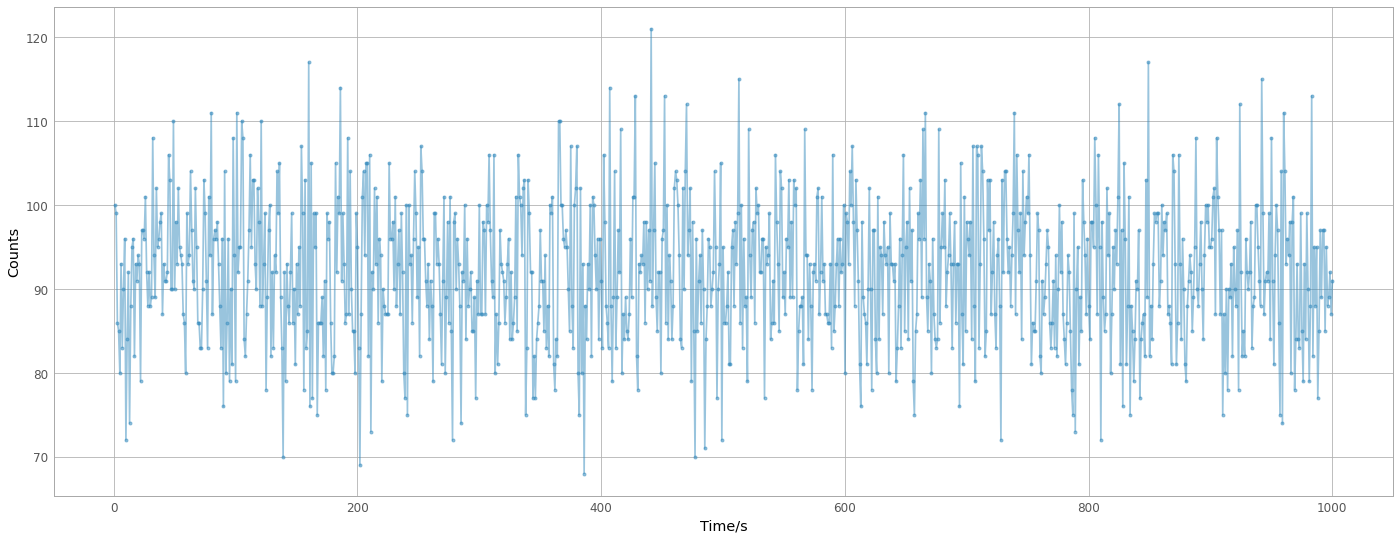

In [38]:
# Create lightcurve
lcurve = "sim_{}_pwr.lc".format(base)
rewrite = True
if rewrite:
    if os.path.exists(lcurve):
        os.remove(lcurve)
    comm = ("makelc EvtFile={} Lightcurve={} length=1000.0 dt=1.0".format(evtfile, lcurve))
    run_comm(comm, "Creating lightcurve")
else:
    print("Light curve ({}) already exists: it will not be overwritten".format(lcurve))
    
# convert light curve to TIME COUNTS to plot
comm = ("fdump infile='{}[COUNTS][col TIME=#row*TIMEDEL, COUNTS]' clobber=yes outfile=check_lc.txt col='-' row='-' ".format(lcurve) +
        "prhead=no showrow=no showunit=no")

run_comm(comm, "Converting lc to TIME, COUNTS")
datalc = pandas.read_table("check_lc.txt", skiprows=0, sep="\s+")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24,9))
ax.plot(datalc.TIME, datalc.COUNTS,'.-', alpha=0.5)
ax.set_xlabel("Time/s")
ax.set_ylabel("Counts")
#os.remove("check_lc.txt")


### $\textbf{Exercise}$: Use the FITS row filter options (fhelp rowfilter) to select only events that belong to our source and that are in the energy range between 0.5 keV and 1.0 keV.

Creating lightcurve
makelc EvtFile=evt_mcrab_lightcurve_pwr.fits[EVENTS][(SIGNAL>=0.5)&&(SIGNAL<=1)&&(SRC_ID[1]==1)] Lightcurve=sim_mcrab_pwr_filt.lc length=1000.0 dt=1.0
Converting lc to TIME, COUNTS
fdump infile='sim_mcrab_pwr_filt.lc[COUNTS][col TIME=#row*TIMEDEL, COUNTS]' clobber=yes outfile=check_lc.txt col='-' row='-' prhead=no showrow=no showunit=no


Text(0, 0.5, 'Counts')

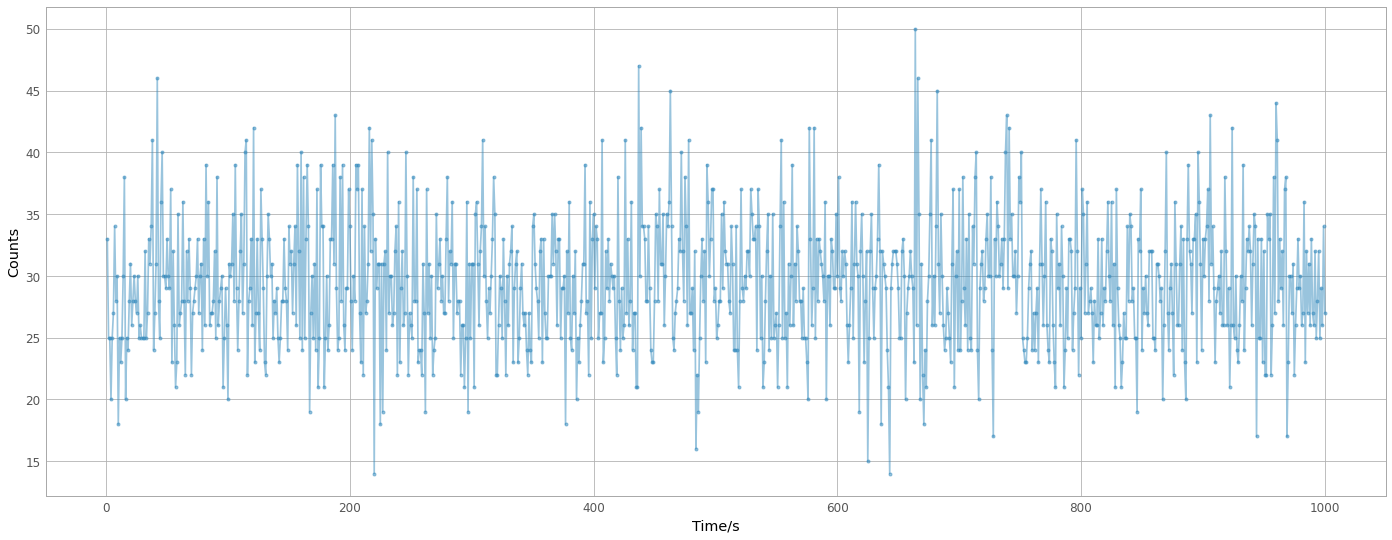

In [39]:
evtfile = "evt_{}_lightcurve_pwr.fits".format(base)
lcurve_filt = "sim_{}_pwr_filt.lc".format(base)
rewrite = True
if rewrite:
    if os.path.exists(lcurve):
        os.remove(lcurve)
    comm = ("makelc EvtFile={}[EVENTS][(SIGNAL>=0.5)&&(SIGNAL<=1)&&(SRC_ID[1]==1)] Lightcurve={} length=1000.0 dt=1.0".format(evtfile, lcurve_filt))
    run_comm(comm, "Creating lightcurve")
else:
    print("Light curve ({}) already exists: it will not be overwritten".format(lcurve))
    
# convert light curve to TIME COUNTS to plot
comm = ("fdump infile='{}[COUNTS][col TIME=#row*TIMEDEL, COUNTS]' clobber=yes outfile=check_lc.txt col='-' row='-' ".format(lcurve_filt) +
        "prhead=no showrow=no showunit=no")

run_comm(comm, "Converting lc to TIME, COUNTS")
datalc = pandas.read_table("check_lc.txt", skiprows=0, sep="\s+")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24,9))
ax.plot(datalc.TIME, datalc.COUNTS,'.-', alpha=0.5)
ax.set_xlabel("Time/s")
ax.set_ylabel("Counts")
